In [1]:
import pandas as pd
import numpy as np 

from gensim import corpora
from gensim.models import LsiModel, CoherenceModel
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.matutils import corpus2dense, corpus2csc, Sparse2Corpus

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

import pyLDAvis
import pyLDAvis.lda_model

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')


In [4]:
data = pd.read_csv("data/preprocessed.csv")
data_spotify = pd.read_csv("data/preprocessed_spotify.csv")
X = data['clean_lyrics'].apply(str.split)

## Latent Dirichlet Allocation

In [5]:
# Define helper function to print and return top words
def get_topic_words(lda_model, feature_names, n_words=10, print_words= False):
    topic_words = {}
    for topic_idx, topic in enumerate(lda_model.components_):
        # words = [feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]]
        # topic_words[f"Topic {topic_idx}"] = words

         # Get words and their weights
        word_weights = {feature_names[i]: topic[i] for i in range(len(feature_names))}
        # Sort words by their weights in descending order
        sorted_words = dict(sorted(word_weights.items(), key=lambda item: item[1], reverse=True))
        topic_words[f"Topic {topic_idx}"] = sorted_words

        # print if needed
        if print_words:
            message = "\nTopic # {}:\n".format(topic_idx)
            message += " ;".join([feature_names[i] for i in topic.argsort()[:-n_words - 1 :-1]])
            print(message)

    return topic_words

# Define a function to compute coherence score using gensim
def compute_coherence_score(lda_model, corpus, dictionary, feature_names):
    topics = []
    for topic_id in range(lda_model.n_components):
        topic_words = [feature_names[i] for i in np.argsort(lda_model.components_[topic_id])[::-1]]
        topics.append(topic_words)
    
    coherence_model = CoherenceModel(topics=topics, texts=corpus, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    return coherence_score

In [6]:
tfidf = TfidfVectorizer(min_df= 0.01, max_df= 0.6, ngram_range= (1,4))
X = tfidf.fit_transform(data_spotify['clean_lyrics'])
feature_names = tfidf.get_feature_names_out()

# Create a dictionary and a corpus
corpus = [text.split() for text in data_spotify['clean_lyrics']]
dictionary = Dictionary(corpus)

In [58]:
coherences = []
perplexities = []

from tqdm import tqdm
for nn in tqdm(range(2,22,2)):
    lda = LatentDirichletAllocation(n_components= nn, random_state= 0)
    lda.fit_transform(X)
    perplexities.append(lda.perplexity(X))
    coherences.append(compute_coherence_score(lda, corpus, dictionary, feature_names))
    

100%|██████████| 10/10 [1:03:44<00:00, 382.49s/it]


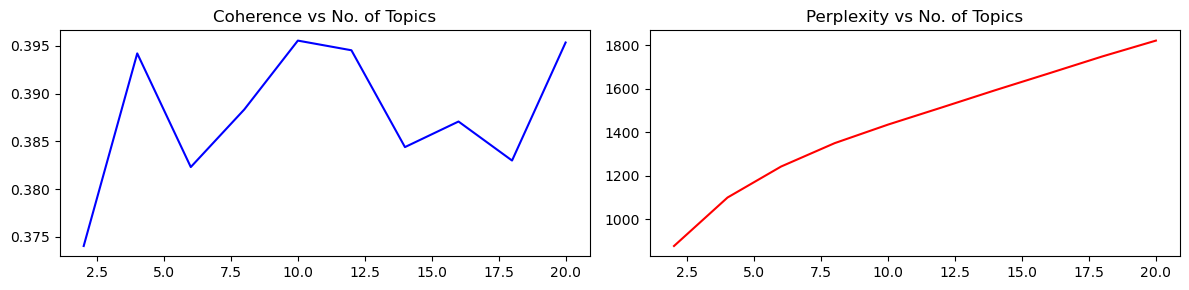

In [59]:
fig,axs = plt.subplots(figsize= (12,3), ncols= 2)
axs[0].plot(range(2,22,2), coherences, color= "blue")
axs[0].set_title("Coherence vs No. of Topics", fontsize= 12)

axs[1].plot(range(2,22,2), perplexities, color= "red")
axs[1].set_title("Perplexity vs No. of Topics", fontsize= 12)

plt.tight_layout();
fig.savefig("images/perplexity_coherence.png")

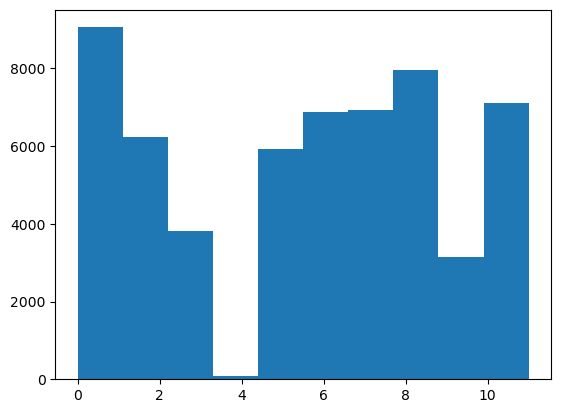

In [7]:
lda = LatentDirichletAllocation(n_components= 12, random_state= 29, max_iter= 20)
doc_topic = lda.fit_transform(X)


plt.hist(np.argmax(doc_topic, axis= 1)); 
topic_words = get_topic_words(lda, feature_names, n_words= 100, print_words= False);

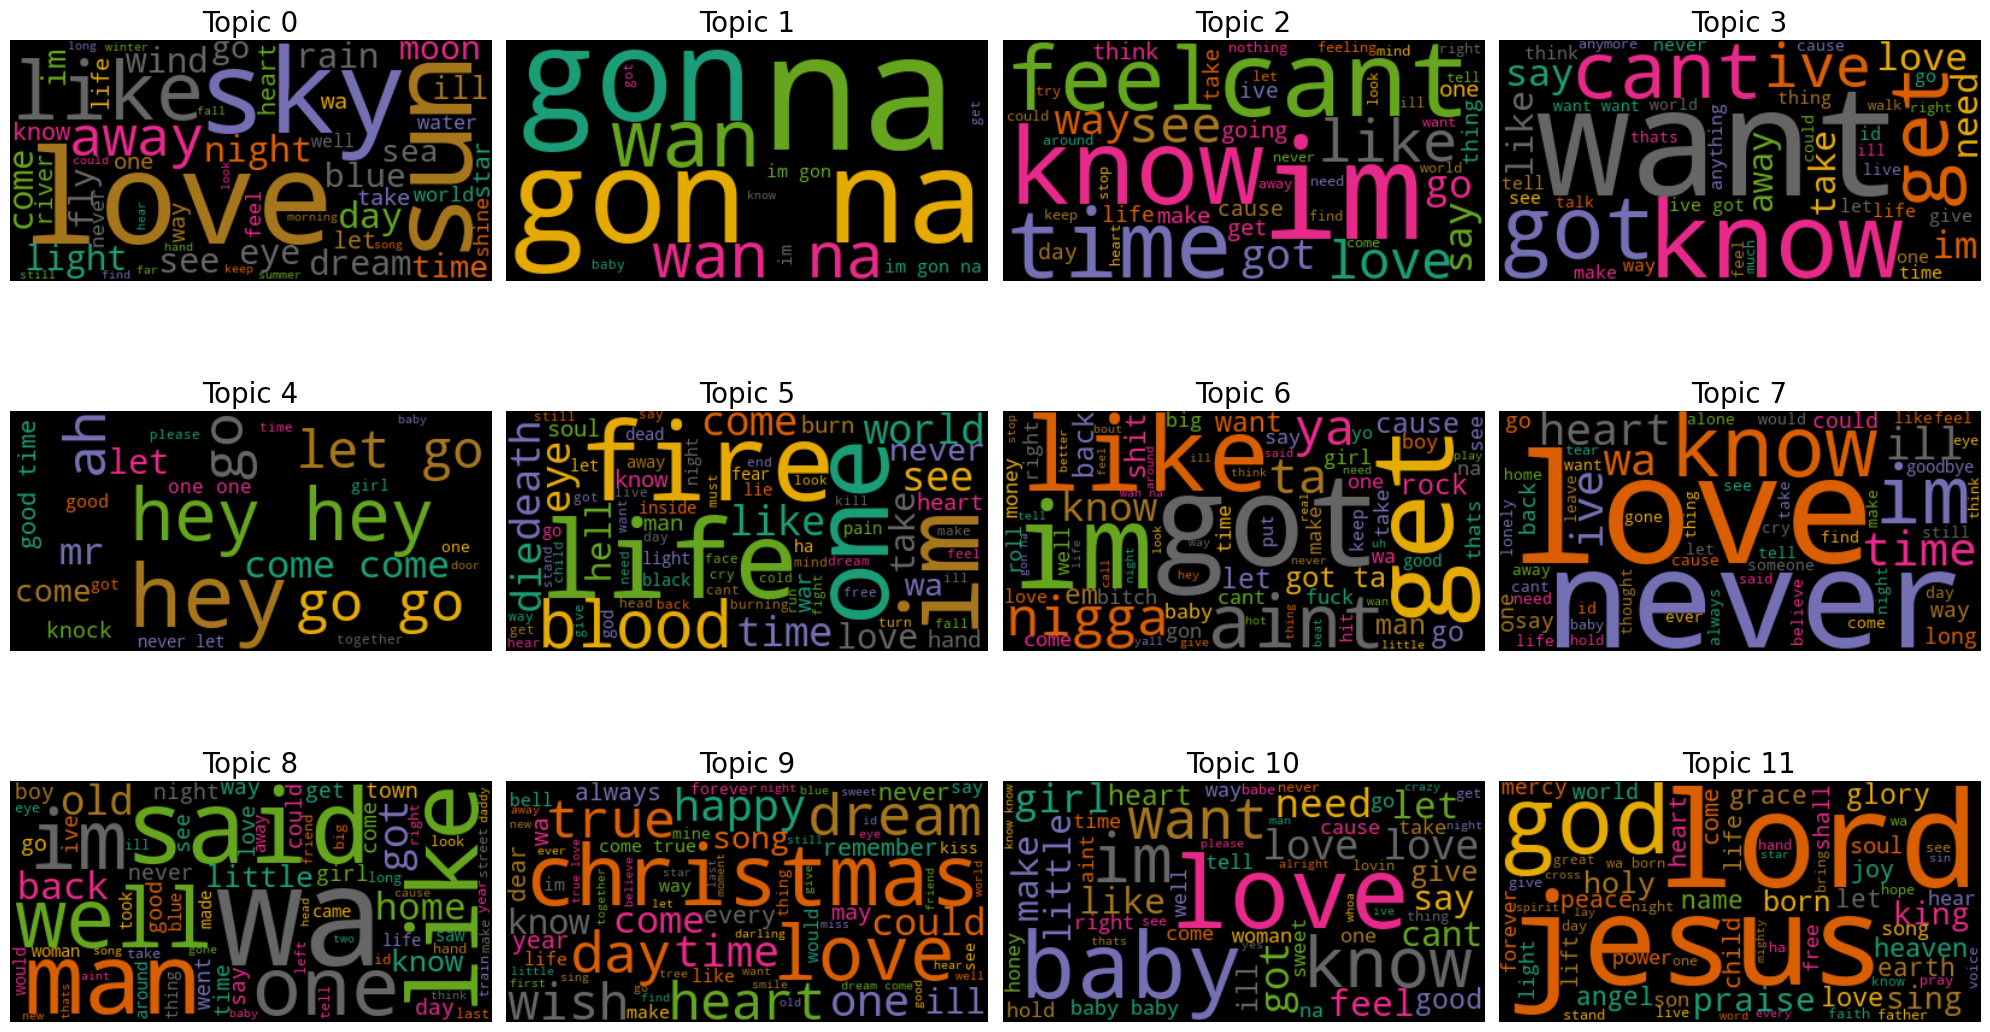

In [8]:
fig,axs = plt.subplots(figsize= (20,12), ncols= 4, nrows= int(np.ceil(lda.n_components/4)) )


def plot_wordcloud(words, title, ax):
    wordcloud = WordCloud(background_color='black', contour_color='steelblue', contour_width=1,
                          colormap='Dark2_r', min_font_size= 10).generate_from_frequencies(words)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title, fontsize= 20)
    ax.axis('off')

ii = 0; jj = 0
# Turn off the axis for each subplot
for ax in axs.flatten():
    ax.axis('off')

for topic, words in topic_words.items():
    plot_wordcloud(words, topic, axs[ii][jj])
    if jj == 3:
        jj = 0
        ii += 1
    else:
        jj += 1

plt.tight_layout();


In [21]:
# print most common n-grams for each topic to get the topic name
# lda_topic = pd.DataFrame(doc_topic).idxmax(axis= 1)

# tfidf_ngram = TfidfVectorizer(ngram_range= (2,5), min_df= 0.01, max_df= 0.4)
# dt_ngram = tfidf_ngram.fit_transform(data_spotify['clean_lyrics'])
# ngram_names = tfidf_ngram.get_feature_names_out()

# for tt in range(0, lda.n_components):
#     print_str = "Topic " + str(tt) + ": "
#     print_str = print_str + "; ".join(pd.DataFrame(tfidf_ngram.transform(data_spotify.loc[lda_topic == tt, 'clean_lyrics']).mean(axis=0).A1, 
#                 index= ngram_names, columns= [tt]).sort_values(tt, ascending= False).head(5).index.tolist()) 
#     print(print_str)

In [103]:
import joblib
joblib.dump(lda, 'lda_model.pkl')
joblib.dump(tfidf, 'tfidf.pkl')

['tfidf.pkl']

In [47]:
# Prepare LDAvis visualization
lda_vis = pyLDAvis.lda_model.prepare(lda, X, tfidf)
pyLDAvis.show(lda_vis, local= False)

Serving to http://127.0.0.1:8888/    [Ctrl-C to exit]


127.0.0.1 - - [25/Aug/2024 10:17:32] "GET / HTTP/1.1" 200 -



stopping Server...


In [ ]:
lda.transform(tfidf.transform(data.query("Artist=='Taylor Swift'")['clean_lyrics']))

array([[0.01176652, 0.01176643, 0.89411316, 0.01176559, 0.0117635 ,
        0.01176423, 0.01176581, 0.01176502, 0.01176536, 0.01176437],
       [0.013434  , 0.87909906, 0.01343386, 0.01343318, 0.01343279,
        0.01343278, 0.01343376, 0.01343434, 0.01343303, 0.0134332 ],
       [0.01132572, 0.54835106, 0.01132611, 0.01132558, 0.01132613,
        0.01132513, 0.01132623, 0.01132622, 0.36104247, 0.01132535],
       [0.01393311, 0.01393365, 0.87460083, 0.01393328, 0.01393219,
        0.01393148, 0.01393268, 0.0139366 , 0.0139329 , 0.01393329],
       [0.01335793, 0.8797735 , 0.01335858, 0.01335643, 0.01335708,
        0.0133566 , 0.01336239, 0.01335796, 0.01335737, 0.01336218],
       [0.01141207, 0.51303766, 0.01141227, 0.01141156, 0.01141155,
        0.01141066, 0.01141418, 0.01141171, 0.39566188, 0.01141644],
       [0.01884395, 0.83039943, 0.01884562, 0.01884578, 0.01884482,
        0.01884265, 0.01884463, 0.01884365, 0.01884716, 0.0188423 ],
       [0.01363284, 0.01363465, 0.6240285